<a href="https://colab.research.google.com/github/vlad-danaila/machine-learning-workout/blob/master/Cancer_detection_custom_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision

**Data download and unzip**

In [0]:
# To remove folder
!rm -vrf "/content/histopathological image dataset for ET"
!rm -vrf "/content/dataset"
!rm -vrf "/content/Readme.txt"
!rm -vrf "/content/dataset.zip"
!rm -vrf "/content/histopathological image dataset for ET.zip"

In [0]:
dataset_url = 'https://ndownloader.figshare.com/articles/7306361/versions/2'
file_name = 'dataset.zip'
def downloadFile(file_url, file_name):
  import requests as req
  resp = req.get(file_url, stream = True)
  with open(file_name, 'wb') as f:
    for chunk in resp:
      f.write(chunk)
downloadFile(dataset_url, file_name)

In [8]:
!unzip dataset.zip
!unzip "histopathological image dataset for ET.zip"
!mkdir "dataset"
!mkdir "dataset/0_normal"
!mkdir "dataset/1_abnormal"
!cp -r "/content/histopathological image dataset for ET/EA/." "dataset/1_abnormal"
!cp -r "/content/histopathological image dataset for ET/EH/Complex/." "dataset/1_abnormal"
!cp -r "/content/histopathological image dataset for ET/EH/Simple/." "dataset/1_abnormal"
!cp -r "/content/histopathological image dataset for ET/EP/." "dataset/1_abnormal"

!cp -r "/content/histopathological image dataset for ET/NE/Follicular/." "dataset/0_normal"
!cp -r "/content/histopathological image dataset for ET/NE/Luteal/." "dataset/0_normal"
!cp -r "/content/histopathological image dataset for ET/NE/Menstrual/." "dataset/0_normal"

Archive:  dataset.zip
 extracting: histopathological image dataset for ET.zip  
 extracting: Readme.txt              
Archive:  histopathological image dataset for ET.zip
   creating: histopathological image dataset for ET/
   creating: histopathological image dataset for ET/EA/
  inflating: histopathological image dataset for ET/EA/1509779.JPG  
  inflating: histopathological image dataset for ET/EA/1509806.JPG  
  inflating: histopathological image dataset for ET/EA/1510326.JPG  
  inflating: histopathological image dataset for ET/EA/1510326ги2гй.JPG  
  inflating: histopathological image dataset for ET/EA/1510326ги3гй.JPG  
  inflating: histopathological image dataset for ET/EA/1510880.JPG  
  inflating: histopathological image dataset for ET/EA/1512199.JPG  
  inflating: histopathological image dataset for ET/EA/1512199ги2гй.JPG  
  inflating: histopathological image dataset for ET/EA/1513106.JPG  
  inflating: histopathological image dataset for ET/EA/1513106ги2гй.JPG  
  inflatin

**Data loading**

In [0]:
import torch as t
import torchvision as tv
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.nn import Linear, BCEWithLogitsLoss
import sklearn as sk
import sklearn.metrics

In [0]:
DATASET_ROOT = 'dataset'
BATCH_SIZE = 128
TRAIN_RATIO = 0.65

In [0]:
#normalization = .5, .5, .5
transforms = tv.transforms.Compose([
    tv.transforms.Resize(200),
    tv.transforms.RandomHorizontalFlip(),
    tv.transforms.RandomVerticalFlip(),
    tv.transforms.RandomRotation(30),
    tv.transforms.ToTensor(),
    tv.transforms.Lambda(lambda t: t.cuda()),
    # tv.transforms.Normalize(normalization, normalization)
])
y_transform = tv.transforms.Lambda(lambda y: t.tensor(y, dtype=t.float32, device = 'cuda:0'))

dataset = ImageFolder(DATASET_ROOT, transforms, target_transform = y_transform)
# dataset = ImageFolder(DATASET_ROOT, transforms)
TRAIN_SIZE = int(len(dataset) * TRAIN_RATIO)
TEST_SIZE = len(dataset) - TRAIN_SIZE
dataset_train, dataset_test = t.utils.data.random_split(dataset, [TRAIN_SIZE, TEST_SIZE])

loader_train = DataLoader(dataset_train, BATCH_SIZE, shuffle = True)
loader_test = DataLoader(dataset_test, BATCH_SIZE, shuffle = False)

In [0]:
def to_numpy(x):
  return x.cpu().detach().numpy()

**Define Model**

In [0]:
cnn = t.nn.Sequential(
    t.nn.Conv2d(3, 32, 3, padding = 1),
    t.nn.ReLU(inplace = True),
       
    t.nn.MaxPool2d(2),
    
    t.nn.BatchNorm2d(32),
    t.nn.Conv2d(32, 32, 3, padding = 1),
    t.nn.ReLU(inplace = True),
    
    t.nn.MaxPool2d(2),
    
    t.nn.Dropout2d(0.1),
    t.nn.BatchNorm2d(32),
    t.nn.Conv2d(32, 64, 3, padding = 1),
    t.nn.ReLU(inplace = True),
    
    t.nn.MaxPool2d(2),
    
    t.nn.Dropout2d(0.2),
    t.nn.BatchNorm2d(64),
    t.nn.Conv2d(64, 64, 3, padding = 1),
    t.nn.ReLU(inplace = True),
    
    t.nn.MaxPool2d(2),
     
    t.nn.Dropout2d(0.2),
    t.nn.BatchNorm2d(64),
    t.nn.Conv2d(64, 128, 3, padding = 1),
    t.nn.ReLU(inplace = True),
    
    t.nn.MaxPool2d(2),
    
    t.nn.Dropout2d(0.3),
    t.nn.BatchNorm2d(128),
    t.nn.Conv2d(128, 128, 3, padding = 1),
    t.nn.ReLU(inplace = True),
    
    t.nn.MaxPool2d(2)  
)
classification = t.nn.Sequential(
    t.nn.Flatten(),
    t.nn.Dropout(0.4),
    t.nn.Linear(128 * 3 * 4, 500),
    t.nn.ReLU(inplace = True),
    
    t.nn.Dropout(0.3),
    t.nn.Linear(500, 100),
    t.nn.ReLU(inplace = True),
    
    t.nn.Linear(100, 1)
)
model = t.nn.Sequential(
  cnn, classification
)
model = model.cuda()

**Train & Evaluate**

In [0]:
len_train = len(loader_train)
len_test = len(loader_test)

losses_train, losses_test = [], []
acc_train, acc_test = [], []
recall_train, recall_test = [], []
precision_train, precision_test = [], []

def train_eval(optimizer, epochs):
  loss_fn = BCEWithLogitsLoss()

  for epoch in range(epochs):
    train_epoch_acc, train_epoch_recall, train_epoch_precision, train_epoch_loss = 0, 0, 0, 0
    test_epoch_acc, test_epoch_recall, test_epoch_precision, test_epoch_loss = 0, 0, 0, 0

    # Train
    model.train()
    for x, y in loader_train:
      y_pred = model.forward(x).view(-1)
      loss = loss_fn(y_pred, y)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      y_pred, y = to_numpy(y_pred), to_numpy(y)
      pred = y_pred > 0
      train_epoch_loss += loss
      train_epoch_acc += sk.metrics.accuracy_score(y, pred)
      train_epoch_recall += sk.metrics.recall_score(y, pred)
      train_epoch_precision += sk.metrics.precision_score(y, pred)
    losses_train.append(train_epoch_loss / len_train)
    acc_train.append(train_epoch_acc / len_train)
    recall_train.append(train_epoch_recall / len_train)
    precision_train.append(train_epoch_precision / len_train)
  
    # Evaluate
    model.eval()
    with t.no_grad():
      for x, y in loader_test:
        y_pred = model.forward(x).view(-1)
        loss = loss_fn(y_pred, y)
        y_pred, y = to_numpy(y_pred), to_numpy(y)
        pred = y_pred > 0
        test_epoch_loss += loss
        test_epoch_acc += sk.metrics.accuracy_score(y, pred)
        test_epoch_recall += sk.metrics.recall_score(y, pred)
        test_epoch_precision += sk.metrics.precision_score(y, pred)
      losses_test.append(test_epoch_loss / len_test)
      acc_test.append(test_epoch_acc / len_test)
      recall_test.append(test_epoch_recall / len_test)
      precision_test.append(test_epoch_precision / len_test)
  
    print('Epoch {} acc {} recall {} precision {}'.format(epoch + 1, acc_test[-1], recall_test[-1], precision_test[-1]))
  print('Ended training')

In [50]:
train_eval(t.optim.Adam(model.parameters(), lr = 1e-3), 4)
train_eval(t.optim.Adam(model.parameters(), lr = 1e-4), 5)
train_eval(t.optim.Adam(model.parameters(), lr = 1e-5), 5)

Epoch 1 acc 0.6505208333333333 recall 0.9799036504204461 precision 0.6444239654787187
Epoch 2 acc 0.6435763888888889 recall 0.9743359620557137 precision 0.6407690175653982
Epoch 3 acc 0.6692708333333334 recall 0.9463012996687876 precision 0.6644351783155371
Epoch 4 acc 0.7043402777777777 recall 0.8482654376000602 precision 0.7224840407080707
Ended training
Epoch 1 acc 0.7112847222222222 recall 0.852369116116124 precision 0.7278246800013408
Epoch 2 acc 0.7236111111111111 recall 0.8356044028579989 precision 0.7487329927312533
Epoch 3 acc 0.7076388888888889 recall 0.7987596461987813 precision 0.7485489062885712
Epoch 4 acc 0.7057291666666666 recall 0.7722546302658949 precision 0.7590132964259333
Epoch 5 acc 0.7154513888888889 recall 0.7918374967044388 precision 0.7602801325762948
Ended training
Epoch 1 acc 0.7151041666666667 recall 0.7802537091152932 precision 0.7667285010528578
Epoch 2 acc 0.7114583333333333 recall 0.7817936275341637 precision 0.7612380128935233
Epoch 3 acc 0.71927083333

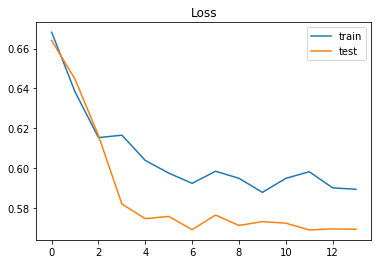

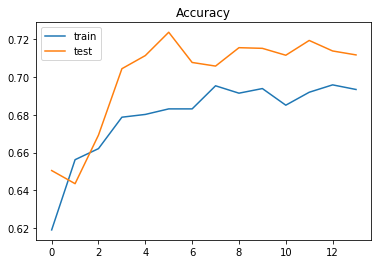

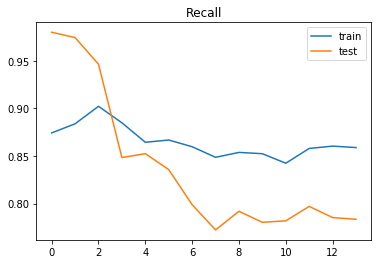

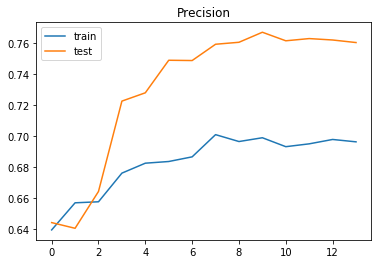

In [51]:
plt.plot(range(len(losses_train)), losses_train, label = 'train')
plt.plot(range(len(losses_test)), losses_test, label = 'test')
plt.title('Loss')
plt.legend()
plt.show()

plt.plot(range(len(acc_train)), acc_train, label = 'train')
plt.plot(range(len(acc_test)), acc_test, label = 'test')
plt.title('Accuracy')
plt.legend()
plt.show()

plt.plot(range(len(recall_train)), recall_train, label = 'train')
plt.plot(range(len(recall_test)), recall_test, label = 'test')
plt.title('Recall')
plt.legend()
plt.show()

plt.plot(range(len(precision_train)), precision_train, label = 'train')
plt.plot(range(len(precision_test)), precision_test, label = 'test')
plt.title('Precision')
plt.legend()
plt.show()

In [52]:
max(acc_test)

0.7236111111111111